In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [2]:
import os
import shutil

# Define the folder to clear
folder_to_clear = '/kaggle/working/'

# Check if the folder exists
if os.path.exists(folder_to_clear):
    # Loop through all files and directories in the folder
    for filename in os.listdir(folder_to_clear):
        file_path = os.path.join(folder_to_clear, filename)
        # If it's a file, remove it
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        # If it's a directory, remove it along with its contents
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

print("Folder cleared.")


Folder cleared.


In [3]:
import os

# Define the folder path
folder_path = '/kaggle/input/weed-detection/train'

# Count the number of files in the folder
file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"Number of files in {folder_path}: {file_count}")


Number of files in /kaggle/input/weed-detection/train: 1662


In [4]:
import os
import shutil
from PIL import Image

# Define source and destination paths
source_dir = "/kaggle/input/weed-detection/train"
destination_dir = "/kaggle/working/"

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Loop through all files in the source directory
for root, _, files in os.walk(source_dir):
    for file in files:
        file_path = os.path.join(root, file)
        
        # Try to open the file as an image to check if it’s valid
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify that it is an image
        except (IOError, SyntaxError):
            # If it fails, treat it as a non-image file and copy it
            shutil.copy(file_path, destination_dir)
            print(f"Copied non-image file: {file_path}")


Copied non-image file: /kaggle/input/weed-detection/train/_annotations.coco.json


In [5]:
import json

# Path to the annotations file
annotations_file = "/kaggle/working/_annotations.coco.json"

# Load the JSON data
with open(annotations_file, 'r') as f:
    coco_data = json.load(f)

# Extract categories (classes)
categories = coco_data.get("categories", [])

# Find number of classes and their names
num_classes = len(categories)
class_names = [category['name'] for category in categories]

# Print the results
print(f"Number of Classes: {num_classes}")
print("Class Names:", class_names)


Number of Classes: 2
Class Names: ['grass-weeds', '0 ridderzuring']


In [6]:
import os
import json
import shutil
from tqdm import tqdm

# Define paths
images_dir = "/kaggle/input/weed-detection/train"
annotations_file = "/kaggle/working/_annotations.coco.json"
output_dir = "/kaggle/working/yolo_format"

# Create output directories
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f"{output_dir}/images", exist_ok=True)
os.makedirs(f"{output_dir}/labels", exist_ok=True)

# Load COCO annotations
with open(annotations_file) as f:
    coco_data = json.load(f)

# Get mapping of category_id to class_id (YOLO expects class IDs to start at 0)
categories = coco_data["categories"]
category_id_to_class_id = {cat["id"]: idx for idx, cat in enumerate(categories)}

# Convert annotations
for annotation in tqdm(coco_data["annotations"], desc="Converting annotations"):
    image_id = annotation["image_id"]
    bbox = annotation["bbox"]  # [x_min, y_min, width, height]
    category_id = annotation["category_id"]

    # Load image details
    image_info = next(img for img in coco_data["images"] if img["id"] == image_id)
    img_filename = image_info["file_name"]
    img_width = image_info["width"]
    img_height = image_info["height"]

    # Convert COCO bbox to YOLO format
    x_min, y_min, width, height = bbox
    x_center = (x_min + width / 2) / img_width
    y_center = (y_min + height / 2) / img_height
    norm_width = width / img_width
    norm_height = height / img_height

    # Create YOLO annotation line
    class_id = category_id_to_class_id[category_id]
    yolo_line = f"{class_id} {x_center} {y_center} {norm_width} {norm_height}\n"

    # Save YOLO annotation
    txt_filename = os.path.splitext(img_filename)[0] + ".txt"
    with open(os.path.join(output_dir, "labels", txt_filename), "a") as f:
        f.write(yolo_line)

    # Copy image to the new directory
    shutil.copy(os.path.join(images_dir, img_filename), os.path.join(output_dir, "images", img_filename))

print("Conversion completed!")


Converting annotations: 100%|██████████| 4199/4199 [00:07<00:00, 571.88it/s]

Conversion completed!


In [7]:
# Clone the YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5

# Navigate to the yolov5 folder
%cd yolov5

# Install dependencies
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (11704/11704), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 33.7 MB/s eta 0:00:00


In [8]:
import os
import shutil

# Paths for images and labels
image_dir = '/kaggle/working/yolo_format/images'
label_dir = '/kaggle/working/yolo_format/labels'
missing_labels = []  # Add the names of images with missing labels here

# Create directories for YOLOv5 data
train_images_dir = '/kaggle/working/dataset/images/train'
train_labels_dir = '/kaggle/working/dataset/labels/train'

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)

# Copy only the images with labels
for image_file in os.listdir(image_dir):
    image_name = os.path.splitext(image_file)[0]
    
    label_file = os.path.join(label_dir, f"{image_name}.txt")
    image_path = os.path.join(image_dir, image_file)
    
    if image_file not in missing_labels and os.path.exists(label_file):
        shutil.copy(image_path, os.path.join(train_images_dir, image_file))
        shutil.copy(label_file, os.path.join(train_labels_dir, f"{image_name}.txt"))

print(f"Prepared dataset for training with {len(os.listdir(train_images_dir))} images.")

Prepared dataset for training with 1655 images.


In [9]:
# Define the path for the dataset YAML file
yaml_path = '/kaggle/working/dataset.yaml'

In [10]:
# Write dataset configuration file
with open(yaml_path, 'w') as f:
    f.write(f"""
    path: /kaggle/working/dataset
    train: images/train
    val: images/train  # Use the same training set as validation for simplicity
    nc: 2  # Replace <number_of_classes> with the actual number of classes
    names: ['grass-weeds','0 ridderzuring']  # Replace with your class names
    """)

In [11]:
# Run the training script
!python train.py --img 640 --batch 16 --epochs 50 --data /kaggle/working/dataset.yaml --cfg models/yolov5n.yaml --weights yolov5n.pt --name yolov5_nano_custom --device 0

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5n.pt, cfg=models/yolov5n.yaml, data=/kaggle/working/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoa

In [12]:
# Define the source and destination paths
source_weights_path = '/kaggle/working/yolov5/runs/train/yolov5_nano_custom/weights/best.pt'
#source_weights_path = '/kaggle/working/yolov5/runs/train/yolov5_nano_custom2/weights/best.pt'
destination_path = '/kaggle/working/yolov5_best_weights.pt'

# Copy the weights file to the desired location
!cp {source_weights_path} {destination_path}

print("Model weights saved at:", destination_path)

Model weights saved at: /kaggle/working/yolov5_best_weights.pt


In [13]:
import torch

# Load the model and weights
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/kaggle/working/yolov5_best_weights.pt', force_reload=True)

/opt/conda/lib/python3.10/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-11-15 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


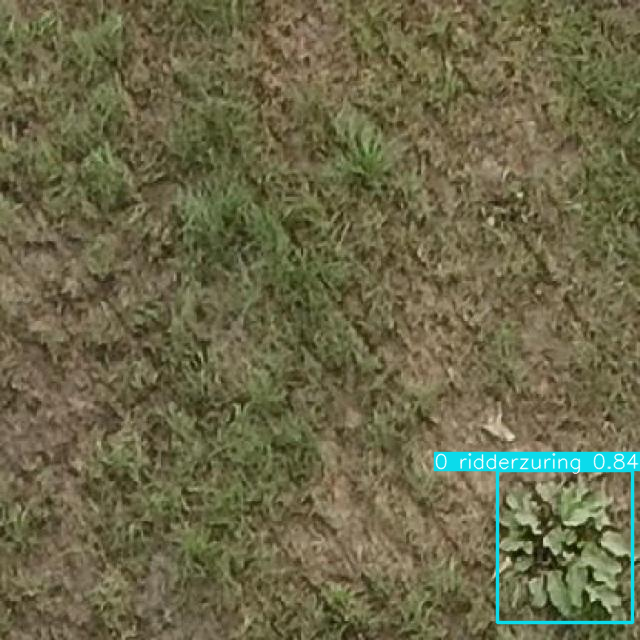

In [15]:
# Path to the image you want to predict
image_path = '/kaggle/input/weed-detection/train/Rumex-obtusifolius-L_0002_jpg.rf.d1ba7d1ebfc636466d5e1de576dafa0a.jpg'

# Perform inference
results = model(image_path)

# Show the results
results.show()

# Optionally save the results
#results.save()  # This will save the annotated images in the 'runs/detect/exp' directory

In [16]:
!python test.py --data /kaggle/working/dataset.yaml --weights /kaggle/working/yolov5_best_weights.pt --device 0


python: can't open file '/kaggle/working/yolov5/test.py': [Errno 2] No such file or directory
